In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import json
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns

# import data 

In [55]:
DATA_FILE = "/gdrive/MyDrive/Colab Notebooks/data.json"
DUMP_FILE = "/gdrive/MyDrive/Colab Notebooks/dump.pkl"

store_columns = (
    "id",  # 음식점 고유번호
    "store_name",  # 음식점 이름
    "branch",  # 음식점 지점 여부
    "area",  # 음식점 위치
    "tel",  # 음식점 번호
    "address",  # 음식점 주소
    "latitude",  # 음식점 위도
    "longitude",  # 음식점 경도
    "category",  # 음식점 카테고리
)

review_columns = (
    "id",  # 리뷰 고유번호
    "store",  # 음식점 고유번호
    "user",  # 유저 고유번호
    "score",  # 평점
    "content",  # 리뷰 내용
    "reg_time",  # 리뷰 등록 시간
)

menu_columns = (
    "id",
    "store",
    "menu_name",
    "price",
)

user_columns = (
    "id",
    "gender",
    "age",
)


def import_data(data_path=DATA_FILE):
    try:
        with open(data_path, encoding="utf-8") as f:
            data = json.loads(f.read())
    except FileNotFoundError as e:
        print(f"`{data_path}` 가 존재하지 않습니다.")
        exit(1)

    stores = []  # 음식점 테이블
    reviews = []  # 리뷰 테이블
    menus = [] # 메뉴 테이블
    users = [] # 유저 테이블
    menu_id = 0

    for d in data:
        categories = [c["category"] for c in d["category_list"]]
        stores.append(
            [
                d["id"],
                d["name"],
                d["branch"],
                d["area"],
                d["tel"],
                d["address"],
                d["latitude"],
                d["longitude"],
                "|".join(categories),
            ]
        )

        for review in d["review_list"]:
            r = review["review_info"]
            u = review["writer_info"]
            user_age = 2021 - int(u["born_year"]) + 1

            reviews.append(
                [r["id"], d["id"], u["id"], r["score"], r["content"], r["reg_time"]]
            )
            users.append(
                [u["id"], u["gender"], user_age]
            )

        for menu in d["menu_list"]:
            menus.append(
                [menu_id, d["id"], menu["menu"], menu["price"]]
            )
            menu_id +=1

    store_frame = pd.DataFrame(data=stores, columns=store_columns)
    review_frame = pd.DataFrame(data=reviews, columns=review_columns)
    memu_frame = pd.DataFrame(data=menus, columns=menu_columns)
    user_frame = pd.DataFrame(data=users, columns=user_columns)

    return {"stores": store_frame, "reviews": review_frame, "menus": memu_frame, "users":user_frame}


def dump_dataframes(dataframes):
    pd.to_pickle(dataframes, DUMP_FILE)


def load_dataframes():
    return pd.read_pickle(DUMP_FILE)


print("[*] Parsing data...")
raw_data = import_data()
print("[+] Done")

print("[*] Dumping data...")
dump_dataframes(raw_data)
print("[+] Done\n")

raw_data = load_dataframes()

[*] Parsing data...
[+] Done
[*] Dumping data...
[+] Done



In [56]:
MUSLIM_PATH = '/gdrive/MyDrive/Colab Notebooks/무슬림친화레스토랑.csv'
CSV_MUSLIM_PATH = pd.read_csv(MUSLIM_PATH, engine='python', encoding='cp949')
print(CSV_MUSLIM_PATH["주소"].head())

0       서울 용산구 우사단로 34 
1       서울 용산구 우사단로 42 
2     부산 금정구 금단로 123-9 
3        인천 연수구 옥련로 31 
4    경남 창원시 성산구 용지로 74 
Name: 주소, dtype: object


In [57]:
MUSLIM_SEOUL_PATH = '/gdrive/MyDrive/Colab Notebooks/무슬림서울만.csv'
CSV_MUSLIM_SEOUL = pd.read_csv(MUSLIM_SEOUL_PATH, engine='python', encoding='cp949')
print(CSV_MUSLIM_SEOUL.head())

   idx store_name                            address category
0    0      우스마니아              서울특별시 용산구 이태원동 137-56   파키스탄음식
1    1  미스터케밥 2호점              서울특별시 용산구 이태원동 136-45     터키음식
2    7        미가미     서울특별시 서초구 서초동 1337-32 서초동 광일빌딩       일식
3    8       패밀리아  서울특별시 강남구 논현동 248-7 임피리얼 팰리스호텔 1층      뷔페식
4    9         깔리                 서울특별시 종로구 명륜4가 171     인도음식


In [58]:
MUSLIM_REVIEW_PATH = '/gdrive/MyDrive/Colab Notebooks/무슬림리뷰만.csv'
CSV_MUSLIM_REVIEW = pd.read_csv(MUSLIM_REVIEW_PATH, engine='python', encoding='cp949')
print(CSV_MUSLIM_REVIEW.head())

  store_name   store
0      우스마니아  308561
1        미가미  155677
2       패밀리아  430186
3         깔리   55195
4      세븐스퀘어  224459


## merge

In [59]:
user_table = raw_data["users"].copy()
user_table.columns

Index(['id', 'gender', 'age'], dtype='object')

In [60]:
review_table = raw_data["reviews"].copy()
review_table.columns

Index(['id', 'store', 'user', 'score', 'content', 'reg_time'], dtype='object')

In [61]:
df_review_user = pd.merge(review_table, user_table, left_on='user', right_on='id')
df_review_user.drop_duplicates("content", inplace=True)
df_review_user.columns

Index(['id_x', 'store', 'user', 'score', 'content', 'reg_time', 'id_y',
       'gender', 'age'],
      dtype='object')

# 전처리

 userID, storeID, rating, title 로 만들기

In [17]:
#skD
raw_store_table = raw_data["stores"].copy()
store_table = raw_store_table[['id', 'store_name','address']]

raw_review_table = raw_data["reviews"].copy()
review_table = raw_review_table[['store','user','score']]

raw_user_table = raw_data["users"].copy()
user_table = raw_user_table[['id','gender','age']]

#muD
raw_muslim_table = CSV_MUSLIM_SEOUL.copy()
muslim_table = raw_muslim_table[["store_name",'address']]
# muslim_table.columns = ['store_name','M_address']
raw_muslim_review = CSV_MUSLIM_REVIEW.copy()

In [18]:
review_table["store"].replace(159620, 159619)
review_table["store"].replace(159622, 159619)

0            15
1            18
2            19
3            37
4            38
          ...  
91393    360499
91394    360505
91395    360514
91396    360514
91397    360515
Name: store, Length: 91398, dtype: int64

In [53]:
musilm_review_table = pd.merge(raw_muslim_review, review_table, on='store', how='left')
print(musilm_review_table.shape)
musilm_review_table.head(20)

(128, 4)


,store_name,store,user,score
0,우스마니아,308561,225842.0,4.0
1,우스마니아,308561,90292.0,4.0
2,미가미,155677,52663.0,5.0
3,패밀리아,430186,NaN,NaN
4,깔리,55195,442382.0,5.0
5,깔리,55195,688218.0,4.0
6,깔리,55195,816257.0,5.0
7,깔리,55195,510431.0,3.0
8,깔리,55195,362703.0,5.0
9,깔리,55195,213564.0,4.0


In [54]:
musilm_store_table.to_csv('/gdrive/MyDrive/Colab Notebooks/MyDF2.csv',encoding="utf-8-sig")

NameError: ignored

In [21]:
store_table.head

<bound method NDFrame.head of             id     store_name                address
0            1           Agal   서울특별시 마포구 동교동 170-13
1            2         Assisy    광주광역시 서구 농성동 631-33
2            3  Battered Sole   서울특별시 용산구 이태원동 118-9
3            4      Chakyoung  부산광역시 해운대구 중2동 1509-5
4            5       Delabobo      서울특별시 강서구 등촌동 689
...        ...            ...                    ...
459983  459996         행복부대찌개     경기도 의정부시 녹양동 154-6
459984  459997           행복부페  경기도 평택시 안중읍 용성리 718-3
459985  459998           행복분식   경기도 광주 퇴촌면 도수리 611-6
459986  459999           행복분식     경상남도 양산시 소주동 147-1
459987  460000           행복분식    경기도 의정부시 의정부동 479-7

[459988 rows x 3 columns]>

# 분석

In [22]:
from sklearn.decomposition import TruncatedSVD

user_review_data = userID, storeID, rating, title

In [23]:
user_store_data = musilm_review_table.copy()

In [24]:
min(user_store_data["score"])

1.0

In [25]:
user_store_rating = user_store_data.pivot_table('score',index='user', columns='store_name').fillna(min(user_store_data["score"]))
store_user_rating = user_store_rating.values.T
store_user_rating.shape

(25, 89)

In [26]:
SVD = TruncatedSVD(n_components=3)

In [27]:
matrix = SVD.fit_transform(store_user_rating)
matrix.shape

(25, 3)

In [28]:
corr = np.corrcoef(matrix)
corr.shape

(25, 25)

In [29]:
store_title = user_store_rating.columns
store_title_list = list(store_title)
store_title_list

['그랜드 키친',
 '깔리',
 '델리인디아',
 '델리팰리스',
 '루나아시아',
 '리틀인디아',
 '명동정',
 '모로코코 카페',
 '미가미',
 '미스터케밥',
 '바바인디아',
 '발우공양',
 '사마르칸트',
 '세븐스퀘어',
 '아건 레스토랑',
 '여우골초밥',
 '예티',
 '오샬',
 '오세계향',
 '옷살',
 '우스마니아',
 '이지인디아',
 '전주식당',
 '종로설렁탕',
 '카페 우즈베키스탄']

In [30]:
store_title = user_store_rating.columns
store_title_list = list(store_title)
coffey_hands = store_title_list.index("예티")
print(coffey_hands) #인덱스 값 찾기

16


In [31]:
corr_coffey_hands = corr[coffey_hands]
list(store_title[(corr_coffey_hands >= 0.9)])[:6] # 유사한 식당 10개

['그랜드 키친', '델리인디아', '델리팰리스', '루나아시아', '리틀인디아', '명동정']

Matrix Factorization


https://yamalab.tistory.com/92?category=747907



In [32]:
import numpy as np


class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """

        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):

            # rating이 존재하는 index를 기준으로 training
            for i in range(self._num_users):
                for j in range(self._num_items):
                    if self._R[i, j] > 0:
                        self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - predicted[x, y], 2)
        return np.sqrt(cost) / len(xi)


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)


    def print_results(self):
        """
        print fit results
        """

        print("User Latent P:")
        print(self._P)
        print("Item Latent Q:")
        print(self._Q.T)
        print("P x Q:")
        print(self._P.dot(self._Q.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_P)
        print("Item Latent bias:")
        print(self._b_Q)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])


# run example
if __name__ == "__main__":
    # rating matrix - User X Item : (7 X 5)
    R = np.array([
        [1, 0, 0, 1, 3],
        [2, 0, 3, 1, 1],
        [1, 2, 0, 5, 0],
        [1, 0, 0, 4, 4],
        [2, 1, 5, 4, 0],
        [5, 1, 5, 4, 0],
        [0, 0, 0, 1, 0],
    ])

    # P, Q is (7 X k), (k X 5) matrix
    factorizer = MatrixFactorization(R, k=3, learning_rate=0.01, reg_param=0.01, epochs=300, verbose=True)
    factorizer.fit()
    factorizer.print_results()

Iteration: 10 ; cost = 0.1770
Iteration: 20 ; cost = 0.1052
Iteration: 30 ; cost = 0.0739
Iteration: 40 ; cost = 0.0551
Iteration: 50 ; cost = 0.0428
Iteration: 60 ; cost = 0.0347
Iteration: 70 ; cost = 0.0291
Iteration: 80 ; cost = 0.0250
Iteration: 90 ; cost = 0.0219
Iteration: 100 ; cost = 0.0194
Iteration: 110 ; cost = 0.0174
Iteration: 120 ; cost = 0.0156
Iteration: 130 ; cost = 0.0142
Iteration: 140 ; cost = 0.0129
Iteration: 150 ; cost = 0.0118
Iteration: 160 ; cost = 0.0108
Iteration: 170 ; cost = 0.0099
Iteration: 180 ; cost = 0.0092
Iteration: 190 ; cost = 0.0085
Iteration: 200 ; cost = 0.0079
Iteration: 210 ; cost = 0.0074
Iteration: 220 ; cost = 0.0069
Iteration: 230 ; cost = 0.0065
Iteration: 240 ; cost = 0.0061
Iteration: 250 ; cost = 0.0058
Iteration: 260 ; cost = 0.0055
Iteration: 270 ; cost = 0.0052
Iteration: 280 ; cost = 0.0050
Iteration: 290 ; cost = 0.0048
Iteration: 300 ; cost = 0.0046
User Latent P:
[[-0.8411138   0.83128165 -0.66431867]
 [-2.31970708 -0.56083186

# 유저 클러스터링

## 음식점에서 id, name, 카테고리 값만 가져오기

## 유저가 리뷰 남긴 음식점의 카테고리 값 가져오기

In [167]:
#review + user
df = df_review_user.drop(['content','id_y','id_x','reg_time'], axis = 1)
df

,store,user,score,gender,age
0,15,68632,5,남,32
121,1216,68632,5,남,32
242,8756,68632,5,남,32
363,9460,68632,5,남,32
484,13745,68632,5,남,32
...,...,...,...,...,...
5394303,360464,158462,5,여,26
5394304,360464,365349,4,남,26
5394305,360464,171391,4,남,29
5394306,360465,518267,5,여,27


In [113]:
#서울무슬림식당
MUSLIM_PATH = '/gdrive/MyDrive/Colab Notebooks/MyDF10.csv'
CSV_MUSLIM_PATH = pd.read_csv(MUSLIM_PATH, engine='python', encoding='cp949')
CSV_MUSLIM_PATH

,Unnamed: 0,id_store_img_1,id_store_img_2,id_store_img_3,id_store,store_name,address_x,id,address_y,category,muslim_friendly,tel,working_time,day_closed,parking,attractions,active,image0,image1,image2,Unnamed: 20
0,0,1,2,3,1,우스마니아,서울특별시 용산구 이태원동 137-56,308561.0,서울시 용산구 이태원동 137-56,인도음식,무슬림 자가 인증,02-798-7155,11:00-22:00,NaN,X,"국립중앙박물관, 이태원 쇼핑거리",1,https://media-cdn.tripadvisor.com/media/photo-...,https://t1.daumcdn.net/cfile/tistory/99CEF14D5...,https://korean.visitseoul.net/comm/getImage?sr...,"INSERT INTO store_image_temp VALUES ('1','1','..."
1,2,4,5,6,3,미가미,서울특별시 서초구 서초동 1337-32 서초동 광일빌딩,155677.0,서울시 서초구 서초동 1337-32,일식,무슬림 프렌들리,02-522-6522,11:00-23:00,명절 연휴,O,"강남역, 선정릉",1,https://t1.daumcdn.net/cfile/tistory/99028E425...,http://www.menupan.com/restaurant/restimg/006/...,https://img1.daumcdn.net/thumb/R800x0/?scode=m...,"INSERT INTO store_image_temp VALUES ('4','3','..."
2,4,7,8,9,5,패밀리아,서울특별시 강남구 논현동 248-7 임피리얼 팰리스호텔 1층,430186.0,서울시 강남구 논현동 248-7 임피리얼 팰리스 호텔 2층,뷔페식,무슬림 프렌들리,02-3440-8090,07:00-22:0-,연중무휴,O,"봉은사, 코엑스, 선정릉",1,https://mp-seoul-image-production-s3.mangoplat...,https://media-cdn.tripadvisor.com/media/photo-...,https://www.imperialpalace.co.kr/img/dining/im...,"INSERT INTO store_image_temp VALUES ('7','5','..."
3,5,10,11,12,6,깔리,서울특별시 종로구 명륜4가 171,55195.0,서울특별시 종로구 명륜4가 170-3 2층,인도음식,무슬림 프렌들리,02-747-5050,12:00-21:30,NaN,X,"창덕궁과 후원, 창경궁, 대학로",1,https://media-cdn.tripadvisor.com/media/photo-...,https://media-cdn.tripadvisor.com/media/photo-...,https://s3-ap-northeast-1.amazonaws.com/dcrevi...,"INSERT INTO store_image_temp VALUES ('10','6',..."
4,8,13,14,15,9,세븐스퀘어,서울특별시 중구 태평로2가 23 더 플라자 2층,224459.0,서울특별시 중구 태평로2가 23-5,뷔페식,무슬림 프렌들리,02-310-7777,06:00-22:00,NaN,O,"덕수궁, 청계천, 명동",1,https://www.hoteltheplaza.com/sp4/img/4_1_seve...,https://www.hoteltheplaza.com/m/_resource/imag...,https://mblogthumb-phinf.pstatic.net/MjAyMDA2M...,"INSERT INTO store_image_temp VALUES ('13','9',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,479,394,395,396,480,오리지날 팍인디아레스토랑,서울특별시 용산구 한남동 763-15,NaN,NaN,아시아음식,무슬림 자가 인증,02-790-1509,11:00~23:00,연중무휴,X,"이태원 우사단길, 이태원쇼핑거리, 전쟁기념관",1,https://media-cdn.tripadvisor.com/media/photo-...,https://mblogthumb-phinf.pstatic.net/MjAxOTA3M...,https://mblogthumb-phinf.pstatic.net/MjAyMDA3M...,"INSERT INTO store_image_temp VALUES ('394','48..."
132,480,397,398,399,481,페트라,서울특별시 용산구 이태원동 552 2층 페트라 레스토랑,431920.0,서울특별시 용산구 이태원동 552,양식,무슬림 자가 인증,02-790-4433,11:00~22:00,연중무휴,X,"전쟁기념관, 경리단길, 이태원쇼핑거리",1,https://media-cdn.tripadvisor.com/media/photo-...,https://t1.daumcdn.net/cfile/tistory/99663C505...,https://t1.daumcdn.net/cfile/tistory/99EB40495...,"INSERT INTO store_image_temp VALUES ('397','48..."
133,481,400,401,402,482,모로코코 카페,서울특별시 용산구 용산동2가 45-9,149007.0,서울특별시 용산구 용산동2가 45-9,양식,무슬림 프렌들리,02-797-8367,12:00~22:00,매주 월요일,O,"전쟁기념관, 경리단길, 남산서울타워",1,https://images.happycow.net/venues/1024/11/13/...,https://mp-seoul-image-production-s3.mangoplat...,https://t1.daumcdn.net/cfile/tistory/99BFB1465...,"INSERT INTO store_image_temp VALUES ('400','48..."
134,484,403,404,405,485,카사블랑카,서울특별시 용산구 용산동2가 44-7,391627.0,서울특별시 용산구 용산동2가 44-8,샌드위치,무슬림 프렌들리,02-797-8367,12:00~22:00,매주 월요일,O,"전쟁기념관, 경리단길, 남산서울타워",1,https://mp-seoul-image-production-s3.mangoplat...,https://media-cdn.tripadvisor.com/media/photo-...,https://images.happycow.net/venues/1024/84/86/...,"INSERT INTO store_image_temp VALUES ('403','48..."


In [173]:
store_table = df.copy()
muslim_table = CSV_MUSLIM_PATH.copy()
muslim_table2 = muslim_table.drop(['id_store_img_1','id_store_img_2','id_store_img_3','Unnamed: 0','store_name','parking','attractions','active','day_closed','image0','image1','image2','working_time','tel','muslim_friendly','Unnamed: 20'],axis=1)
df_merge = pd.merge(muslim_table2, store_table, left_on='id', right_on='store')
df_mergef = df_merge.drop(['address_x','address_y'],axis=1)
df_mergef
# duplicateDFRow = df_mergef[df_mergef.duplicated('store')]
# duplicateDFRow

,id_store,id,category,store,user,score,gender,age
0,1,308561.0,인도음식,308561,90292,4,여,26
1,1,308561.0,인도음식,308561,225842,4,여,23
2,3,155677.0,일식,155677,52663,5,여,29
3,6,55195.0,인도음식,55195,51405,5,남,29
4,6,55195.0,인도음식,55195,132504,4,여,35
...,...,...,...,...,...,...,...,...
78,482,149007.0,양식,149007,358081,3,여,34
79,482,149007.0,양식,149007,219293,4,여,36
80,482,149007.0,양식,149007,46551,5,여,32
81,482,149007.0,양식,149007,382215,4,남,28


### 평점이 높은 순

In [186]:
temp = df_mergef.copy()

tgroup = temp.groupby(["user"])
store_scores = tgroup.mean()
store_scores

,id_store,id,store,score,age
user,,,,,
166,9.0,224459.0,224459.0,5.0,33.0
5142,424.0,344831.0,344831.0,4.0,25.0
5602,255.0,355301.0,355301.0,4.0,29.0
5666,243.0,44333.0,44333.0,3.0,37.0
27836,179.0,285720.0,285720.0,3.0,62.0
...,...,...,...,...,...
782157,6.0,55195.0,55195.0,4.0,45.0
808968,172.0,298567.0,298567.0,3.0,36.0
816257,6.0,55195.0,55195.0,5.0,29.0


# clustering

In [34]:
# user data만 뽑고 중복 제거해서 유저 데이터 모음
musilm_user = musilm_review_table["user"]
musilm_user.drop_duplicates(inplace=True)
musilm_user.dropna(inplace=True)

In [35]:
musilm_user.shape

(89,)

In [91]:
musilm_user

0      225842.0
1       90292.0
2       52663.0
4      442382.0
5      688218.0
         ...   
122    358081.0
123    382215.0
124    219293.0
125     75773.0
126     46551.0
Name: user, Length: 89, dtype: float64

In [92]:
user_table

,id,gender,age
0,68632,남,32
1,389728,여,29
2,68716,여,38
3,774353,여,50
4,115682,남,31
...,...,...,...
91393,17371,여,36
91394,198050,남,28
91395,190766,여,33
91396,201564,여,27


In [192]:
# user 데이터와 merge 해서 데이터 추출
musilm_review_user = pd.merge(musilm_user, user_table, left_on='user', right_on='id', how='inner')
musilm_review_user.drop_duplicates(inplace=True)
print(musilm_review_user.shape)
musilm_review_user.reset_index(drop=True, inplace=True)
musilm_review_user.id.min()

(89, 4)


166

In [147]:
reviewscore = pd.merge(musilm_review_user, scores, left_on='user', right_on='user')
reviewscore

,user,id,gender,age,category,score
0,225842.0,225842,여,23,인도음식,4
1,90292.0,90292,여,26,인도음식,4
2,52663.0,52663,여,29,일식,5
3,442382.0,442382,여,27,인도음식,5
4,816257.0,816257,남,29,인도음식,5
...,...,...,...,...,...,...
78,358081.0,358081,여,34,양식,3
79,382215.0,382215,남,28,양식,4
80,219293.0,219293,여,36,양식,4
81,75773.0,75773,여,30,양식,4


In [37]:
#나이만 추출
musilm_only_user = musilm_review_user[["user","age"]]
#정규화
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(musilm_only_user)
musilm_only_user_normal= pd.DataFrame(features_normal ,columns=['nor_user', 'nor_age',])

musilm_review_nor_user = pd.concat([musilm_review_user, musilm_only_user_normal], axis=1)
musilm_review_nor_user.head()

,user,id,gender,age,nor_user,nor_age
0,225842.0,225842,여,23,0.238406,0.000000
1,90292.0,90292,여,26,0.095210,0.076923
2,52663.0,52663,여,29,0.055458,0.153846
3,442382.0,442382,여,27,0.467161,0.102564
4,688218.0,688218,여,29,0.726864,0.153846


In [38]:
musilm_review_nor_user["gender_m"] = musilm_review_nor_user["gender"].apply(lambda x: 1 if x=='남' else 0 )
musilm_review_nor_user["gender_f"] = musilm_review_nor_user["gender"].apply(lambda x: 1 if x=='여' else 0 )

In [39]:
musilm_review_nor_user.head()

,user,id,gender,age,nor_user,nor_age,gender_m,gender_f
0,225842.0,225842,여,23,0.238406,0.000000,0,1
1,90292.0,90292,여,26,0.095210,0.076923,0,1
2,52663.0,52663,여,29,0.055458,0.153846,0,1
3,442382.0,442382,여,27,0.467161,0.102564,0,1
4,688218.0,688218,여,29,0.726864,0.153846,0,1


In [40]:
df_review_user = musilm_review_nor_user[["id","gender_m","gender_f"]]
df_review_user.head()

,id,gender_m,gender_f
0,225842,0,1
1,90292,0,1
2,52663,0,1
3,442382,0,1
4,688218,0,1


k-means

In [41]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_review_user)
    kmeanModel.fit(df_review_user)
    inertia.append(kmeanModel.inertia_)

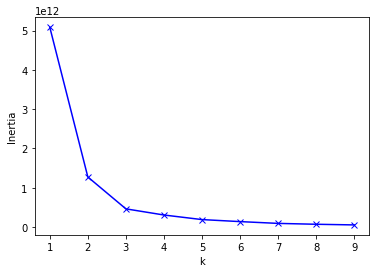

In [42]:
# Plot the elbow
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [43]:
kmeans = KMeans(n_clusters=3).fit(features_normal)

In [44]:
labels = pd.DataFrame(kmeans.labels_)
labeledColleges = pd.concat((musilm_review_user,labels),axis=1)
labeledColleges = labeledColleges.rename({0:'labels'},axis=1)

In [45]:
labeledColleges.head()

,user,id,gender,age,labels
0,225842.0,225842,여,23,0
1,90292.0,90292,여,26,0
2,52663.0,52663,여,29,0
3,442382.0,442382,여,27,0
4,688218.0,688218,여,29,1


In [51]:
sns.lmplot(x='age',y='gender_m',data=labeledColleges,hue='labels',fit_reg=False)

KeyError: ignored